In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
import nltk
import joblib
# Download the WordNet resource
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [7]:
pd.set_option("display.max_colwidth",200)
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [2]:
df_train = pd.read_csv('twitter_training.csv')
df_val = pd.read_csv('twitter_validation.csv')
# concatenate data
df = pd.concat([df_train, df_val], ignore_index=False)
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,2401.0,Borderlands,Positive,I am coming to the borders and I will kill you...,NaN,NaN,NaN,NaN
1,2401.0,Borderlands,Positive,im getting on borderlands and i will kill you ...,NaN,NaN,NaN,NaN
2,2401.0,Borderlands,Positive,im coming on borderlands and i will murder you...,NaN,NaN,NaN,NaN
3,2401.0,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,NaN,NaN,NaN,NaN
4,2401.0,Borderlands,Positive,im getting into borderlands and i can murder y...,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75680 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                              --------------  -----  
 0   2401                                                                                                                                                                                                                                                74681 non-null  float64
 1   Borderlands                                                                

In [4]:
# Remove unnecessary columns
columns_to_drop = ['2401', '3364', 'Facebook', 'Irrelevant',
                   'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣']
df = df.drop(columns_to_drop, axis=1)

# Rename columns
df = df.rename(columns={'im getting on borderlands and i will murder you all ,': 'Tweet', 'Positive': 'Sentiment', 'Borderlands':"Branch"})
df.head()

,Branch,Sentiment,Tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
# check missing values
print(df.isnull().sum())

Branch        999
Sentiment     999
Tweet        1685
dtype: int64


In [6]:
# remove missing values
df.dropna(inplace=True)
# check missing values
df.isnull().sum()  


Branch       0
Sentiment    0
Tweet        0
dtype: int64

In [7]:
# check duplicate values
df.duplicated().sum()

3038

In [8]:
# remove duplicate values 
remove_duplicates = df.drop_duplicates()
df = remove_duplicates
# check duplicate values
df.duplicated().sum()

0

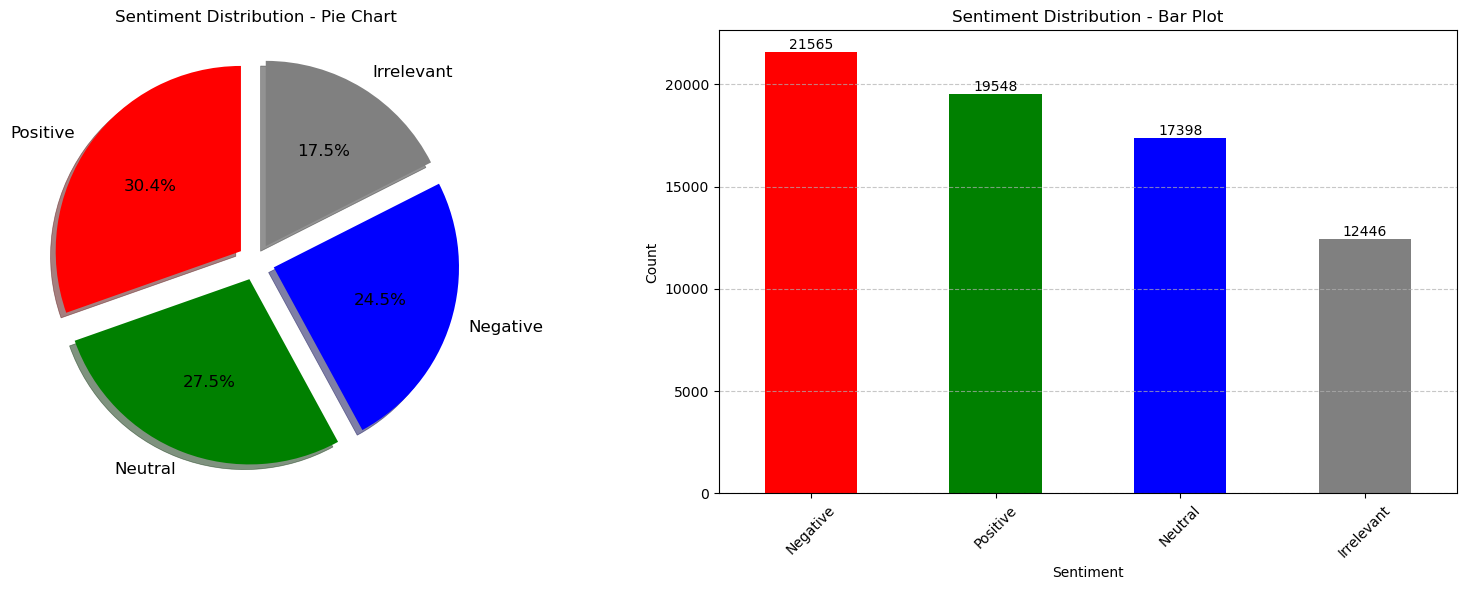

In [9]:
# Define custom colors
colors = ['red', 'green', 'blue', 'gray']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting pie chart for sentiment distribution with custom colors
axs[0].pie(df['Sentiment'].value_counts(), labels=df['Sentiment'].unique(), autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 0.5}, textprops={'fontsize': 12},
            explode=[0.1, 0.1, 0.1, 0.1], colors=colors, shadow=True)
axs[0].set_title('Sentiment Distribution - Pie Chart')

# Plotting bar plot for sentiment distribution
axs[1] = df['Sentiment'].value_counts().plot(kind='bar', color=colors, ax=axs[1])
axs[1].set_title('Sentiment Distribution - Bar Plot')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add text on top of each bar in the bar plot
for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

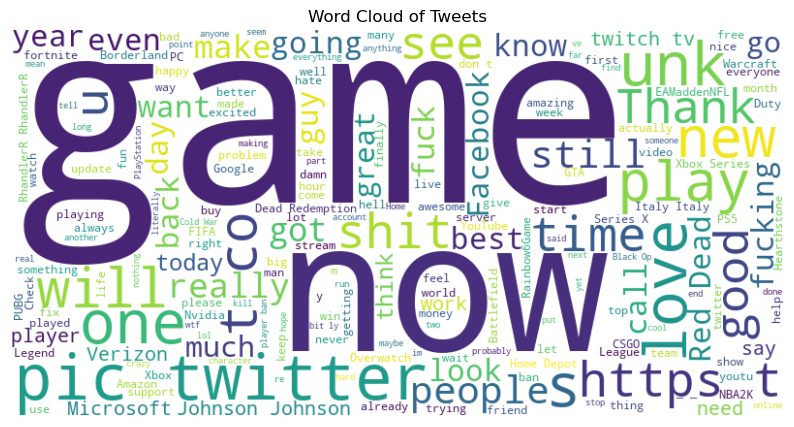

In [10]:
# Concatenate all tweets into a single string
all_tweets_text = ' '.join(df['Tweet'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()


Preprocessing The Data

In [11]:
def filter_non_string(df, column):
    """
    Filter out rows with non-string values in the specified column.
    Convert non-string values to strings.
    """
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df
def normalize_text(text):
    """Convert text to lowercase to ensure consistency across the corpus."""
    return text.lower()
def remove_html_tags(text):
  """Removes HTML tags from a string using regular expressions."""
  clean_text = re.sub(r'<.*?>', '', text)
  return clean_text
def remove_urls(text):
    """Remove URLs or hyperlinks from the text."""
    return re.sub(r'http\S+|www\S+', '', text)
def remove_numbers(text):
    """Exclude numerical digits from the text."""
    return re.sub(r'\d+', '', text)
def remove_punctuation(text):
    """Remove punctuation marks from the text."""
    return text.translate(str.maketrans('', '', string.punctuation))
def tokenize_text(text):
    """Split the text into individual words or tokens."""
    return word_tokenize(text)
def remove_stopwords(tokens):
    """Eliminate common stopwords from the tokenized text."""
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]
def remove_emojis(text):

    """Remove emojis from the text."""
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text
def vectorize_data(text_data):
    # Join the tokenized text into strings
    text_data_strings = [" ".join(tokens) for tokens in text_data]
    # Initialize TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    # Fit and transform the text data to generate TF-IDF vectors
    tfidf_vectors = tfidf_vectorizer.fit_transform(text_data_strings)
    return tfidf_vectors, tfidf_vectorizer        

In [12]:
def preprocess_text(df):
    df = filter_non_string(df, 'Tweet')
    df['Tweet'] = df['Tweet'].apply(normalize_text)
    df['Tweet'] = df['Tweet'].apply(remove_html_tags)
    df['Tweet'] = df['Tweet'].apply(remove_urls)
    df['Tweet'] = df['Tweet'].apply(remove_numbers)
    df['Tweet'] = df['Tweet'].apply(remove_punctuation)
    df['Tweet'] = df['Tweet'].apply(tokenize_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
    df['Tweet'] = df['Tweet'].apply(remove_emojis)
    
    return df
df_processed = preprocess_text(df)


In [13]:
df_processed.head ( n =90)

,Branch,Sentiment,Tweet
0,Borderlands,Positive,"[coming, borders, kill]"
1,Borderlands,Positive,"[im, getting, borderlands, kill]"
2,Borderlands,Positive,"[im, coming, borderlands, murder]"
3,Borderlands,Positive,"[im, getting, borderlands, murder]"
4,Borderlands,Positive,"[im, getting, borderlands, murder]"
...,...,...,...
90,Borderlands,Neutral,"[hate, simple, chaos, modifier, event, chaos, ..."
91,Borderlands,Neutral,"[hate, easy, mayhem, modifier, event, mayhem, ..."
92,Borderlands,Neutral,"[hate, saying, easy, day, event, mayhem, ’, la..."
93,Borderlands,Neutral,"[hate, thinking, easy, mayhem, modifier, event..."


In [14]:
# df_processed contains preprocessed text data
# Convert list of words into a single string for each entry in 'Tweet' column
df_processed['Tweet'] = df_processed['Tweet'].apply(lambda x: ' '.join(x))

# Split data into features (X) and target (y)
X = df_processed['Tweet']  # Features
y = df_processed['Sentiment']  # Target

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (56765,)
Shape of X_test: (14192,)
Shape of y_train: (56765,)
Shape of y_test: (14192,)


Random Forest

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

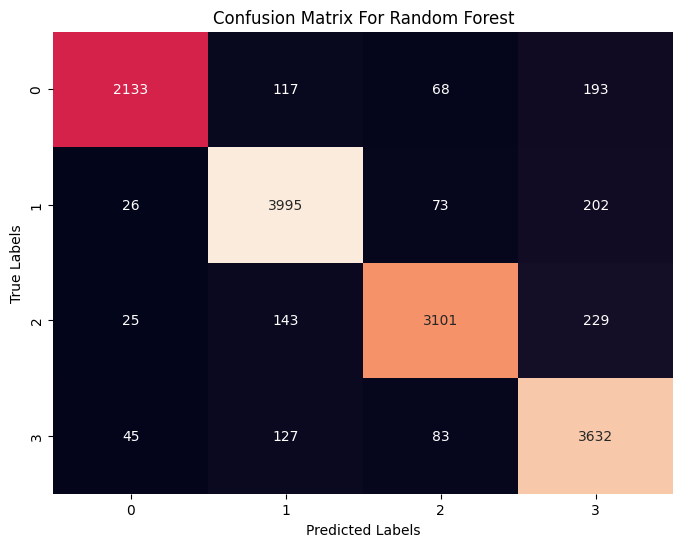

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.96      0.85      0.90      2511
    Negative       0.91      0.93      0.92      4296
     Neutral       0.93      0.89      0.91      3498
    Positive       0.85      0.93      0.89      3887

    accuracy                           0.91     14192
   macro avg       0.91      0.90      0.91     14192
weighted avg       0.91      0.91      0.91     14192



In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a classification report
class_report = classification_report(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix For Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("Classification Report:")
print(class_report)

In [24]:
from sklearn.metrics import accuracy_score

# Accuracy on training data Check if there are Overfitting
train_accuracy = rf_classifier.score(X_train_tfidf, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.9793534748524619


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the best parameters
best_params = {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

# Initialize RandomForestClassifier with the best parameters
clf = RandomForestClassifier(**best_params)

# Train the classifier on the entire training dataset
clf.fit(X_train_tfidf , y_train)

# Make predictions on the test set
predictions = clf.predict(X_test_tfidf)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9050873731679819


In [26]:
from sklearn.metrics import accuracy_score

# Accuracy on training data Check if there are Overfitting
train_accuracy = clf.score(X_train_tfidf, y_train)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.9791068440059896


KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

modelKn = KNeighborsClassifier()
modelKn.fit(X_train_tfidf,y_train)
prediction = modelKn.predict(X_test_tfidf)

predictions = modelKn.predict(X_test_tfidf)


accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8609075535512966


In [169]:


# Accuracy on training data Check if there are Overfitting
train_accuracy = modelKn.score(X_train_tfidf, y_train)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.9211309785959658


Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train_tfidf, y_train) 
predicted_naive = model_naive.predict(X_test_tfidf)

In [29]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes: ",score_naive)


Accuracy with Naive-bayes:  0.7139937993235626


In [31]:
from sklearn.metrics import accuracy_score

# Accuracy on training data Check if there are Overfitting
train_accuracy = model_naive.score(X_train_tfidf, y_train)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.7801638333480138


In [33]:
import pickle
pickle.dump(rf_classifier,open('clf.pkl','wb'))
pickle.dump(vectorizer,open('tfidf.pkl','wb'))



